# 1

### Importing all the packages that are going to be used thoughout the assignment. 

In [1]:
# ! pip install numpy
# ! pip install matplotlib
# ! pip install scikit-learn
# ! pip install scikit-image

%autosave 60
%matplotlib inline
import os
import skimage
from skimage.transform import rescale, resize
import matplotlib
import matplotlib.pyplot as plt
import ntpath
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf

Autosaving every 60 seconds


## <a name="1_1">1.1 Getting Started</a>
***
I've used my implementation of the data reading part from Assignment 1 of this course, as I mentioned before it is generic and could be applied to any other data set.

In [2]:
def get_subdirectories(dir_name):
    '''
        This functions returns a list of all subdirectories' paths under a specific directory name.
        
        params:
            dir_name: str
        returns:
            subdirectories_list: List[str]
    '''
    if (os.path.isdir(dir_name)):
        return [os.path.join(dir_name, subdir_name) for subdir_name in os.listdir(dir_name) if os.path.isdir(os.path.join(dir_name, subdir_name))]
    else:
        return []

def get_files_within_dir(dir_name, ext):
    '''
        This function returns all the files' paths withing a specific directory with the same extension as [ext]
        
        params:
            dir_name: str
            ext: str
        returns:
            all_files_found_list: List[str]
    '''
    if (os.path.isdir(dir_name)):
        return [os.path.join(dir_name, file_name) for file_name in os.listdir(dir_name) if file_name.endswith(ext)]
    else:
        return []
    
def read_images_from_files(filenames, rescale_factor, rgb=True, flatten=False):
    '''
        This function takes a list of images' filenames, reads all the images, and return them based on some parameters given,
        to the function as the rescaling factor, either RGB or grayscale, and either the image will be flattened or not
        
        params: 
            filenames: List[str]
            rescale_factor: float
            rgb: bool (optional) default=True
            flatten: bool (optional) default=False
        return:
            List[Tuple[np.ndarray, Tuple[int, int], str]] -> List[(image, original_size, filename)]
    '''
    def read_image_from_file(filename):
        '''
            This function takes an image's filename, read the image pixels in either RGB or grayscale format as specified,
            resizes the image with the given rescaling factor, flattens the image so it can be one vector on numbers,
            and returns the preprocessed image and its original shape
            
            params: 
                filename: str
            returns:
                img: np.ndarray
                org_size: Tuple[int, int]
        '''
        if rgb:
            flag = 1
        else:
            flag = 0
        img = np.asarray(Image.open(filename))#cv2.imread(filename, flag)
        org_size = img.shape
        img = cv2.resize(img, (int(org_size[0] * rescale_factor), int(org_size[1] * rescale_factor)))
        
        if (flatten==True):
            img = img.flatten()
        return img, org_size
        
    images = []
    for filename in filenames:
        img, org_size = read_image_from_file(filename)
        images.append((img, org_size, filename))
    return images

def get_all_images(dataset_dirname, rescale_factor, RGB=True, flatten=False):
    '''
        This function acts as the main API function, and is responsible for fetching and preprocessing all the images
        within the dataset directory, it uses the already defined helper functions
        
        params:
            dataset_dirname: str
            rescale_factor: float
            RGB: bool
            flatten: bool
        return:
            all_images: List[Tuple[np.ndarray, Tuple[int, int], str]] -> List[(image, original_size, filename)]
    '''
    subdirectories = get_subdirectories(dataset_dirname)
    all_images = []
    for subdir in subdirectories:
        images_filenames = get_files_within_dir(subdir, '.png')
        subdir_images = read_images_from_files(filenames=images_filenames, rescale_factor=rescale_factor, rgb=RGB, flatten=flatten)
        all_images += subdir_images
    return all_images

In [118]:
'''
    Defining the global variables that I will be using to extract and pre-process the image data
        - Dataset directory name (train/test)
        - Rescaling factor as mentioned in the assignment PDF (1/4) -> ((256x256) -> (64x64))
'''
TRAIN_VAL_DIRNAME = "sub1to10"
TEST_DIRNAME = "sub31to40"
RESCALING_FACTOR = 1. / 4.

In [4]:
train_val_data = get_all_images(TRAIN_VAL_DIRNAME, RESCALING_FACTOR, RGB=True, flatten=False)
test_data = get_all_images(TEST_DIRNAME, RESCALING_FACTOR, RGB=True, flatten=False)
print("Number of train/val images {0}".format(len(train_val_data)))
print("Number of test images {0}".format(len(test_data)))

## <a name="1_2">1.2 Template Matching</a>
***
- #### [1.2.1 Construct arrays for all pairs of images](#1_2_1)
- #### [1.2.2 Split the data into train/validation sets](#1_2_2)
- #### [1.2.3 Defining the similarity function](#1_2_3)
- #### [1.2.4 Choosing the right threshold](#1_2_4)
- #### [1.2.5 Evaluating the classification threshold](#1_2_5)

### <a name="1_2_1">1.2.1 Construct arrays for all pairs of images</a>
***
Since storing all pairs of images would be a huge load on the memory, so I just construct array of pairs of images using only their indices in the main images array (*train_val_data*) along with the label (whether two images are the same or not). <br>
I also make sure that I have array for (same faces, different faces, all faces), to be able to split the data fairly into training and validation data, as there is already a hust data imbalance (10K same faces vs. 95K different faces)

In [6]:
train_val_pairs = []
train_val_pairs_same = []
train_val_pairs_diff = []
vis = {}

for i in range(len(train_val_data)):
    for j in range(len(train_val_data)):
        if (i != j and (i, j) not in vis and (j, i) not in vis):
            _, _, f1 = train_val_data[i]
            _, _, f2 = train_val_data[j]

            name1, name2 = f1.split('\\')[1][:-1], f2.split('\\')[1][:-1]

            if (name1 == name2):
                same = 1
            else:
                same = 0

            label = tf.keras.utils.to_categorical(same, num_classes=2)
            train_val_pairs.append((i, j, same))

            if same == 1:
                train_val_pairs_same.append((i, j, same))
            else:
                train_val_pairs_diff.append((i, j, same))
            vis[(i, j)] = True

test_pairs = []
test_pairs_same = []
test_pairs_diff = []
vis = {}

for i in range(len(test_data)):
    for j in range(len(test_data)):
        if (i != j and (i, j) not in vis and (j, i) not in vis):
            _, _, f1 = test_data[i]
            _, _, f2 = test_data[j]
      
            name1, name2 = f1.split('\\')[1][:-1], f2.split('\\')[1][:-1]
      
            if (name1 == name2):
                same = 1
            else:
                same = 0

            label = tf.keras.utils.to_categorical(same, num_classes=2)
            test_pairs.append((i, j, same))

            if same == 1:
                test_pairs_same.append((i, j, same))
            else:
                test_pairs_diff.append((i, j, same))
            vis[(i, j)] = True

### <a name="1_2_2">1.2.2 Split the data into train/validation sets</a>
***
Here I shuffle the data, then take differnt train portions of both (same/different faces), and the same for the validation portions.<br>
Then I construct a training set using a mix of same/difference faces, and a validation set using a mix of same/different faces. <br>
Doing that insures that there will always be same/different faces in both training and validation sets.

In [7]:
import random
# shuffle
random.shuffle(train_val_pairs_same)
random.shuffle(train_val_pairs_diff)
# train_val_pairs_diff = random.sample(train_val_pairs_diff, int(len(train_val_pairs_same) * 5))
# split
print("Train same {0} - Test diff {1}".format(len(train_val_pairs_same), len(train_val_pairs_diff)))

val_same = 0.05
val_diff = 0.05

val_same_sz = int(val_same * len(train_val_pairs_same))
val_diff_sz = int(val_diff * len(train_val_pairs_diff))

print("Validation same {0} - Validation diff {1}".format(val_same_sz, val_diff_sz))

train_same = train_val_pairs_same[:-val_same_sz]
train_diff = train_val_pairs_diff[:-val_diff_sz]
val_same = train_val_pairs_same[-val_same_sz:]
val_diff = train_val_pairs_diff[-val_diff_sz:]

train_pairs = train_same + train_diff
val_pairs = val_same + val_diff

print("train {0} - val {1}".format(len(train_pairs), len(val_pairs)))

Train same 10350 - Test diff 95220
Validation same 517 - Validation diff 4761
train 100292 - val 5278


### <a name="1_2_3">1.2.3 Defining the similarity function</a>
***
I used *template_match* provided by **skimage**, which uses a fast normalized cross-correlation to find the similarity between a template and an image.

In [119]:
from skimage.feature import match_template

def compute_similarity(img1, img2):
    score = match_template(img1, img2)
    return np.round(np.squeeze(score), 6)

### <a name="1_2_4">1.2.4 Choosing the right threshold</a>
***
In order to choose the threshold that could give us best classification accuracy:
- First I computed the similarity scores for all the pairs in the validation set (same faces / different faces).
- Since storing all these pairs of images could take time, I've implemented a generator for that, for an efficient use of memory.
- I've saved my results in numpy arrays, to be able to load them whenever I want.
- **The commented out code is the code that I already ran and saved its result, I am then loading the results from the numpy file as shown**.

In [120]:
def similarity_generator(data_pairs, data):
    for pair in data_pairs:
        i, j, label = pair
        left, right = data[i][0], data[j][0]
        score = compute_similarity(left, right)
        yield score
# same_scores = []
# for x in similarity_generator(val_same[:500], train_val_data):
#     same_scores.append(x)
# diff_scores = []
# for x in similarity_generator(val_diff[:500], train_val_data):
#     diff_scores.append(x)
    
# np.save('same_scores', same_scores)
# np.save('diff_scores', diff_scores)
same_scores = np.load('same_scores.npy')
diff_scores = np.load('diff_scores.npy')

The reason I calculated all the similarity scores of the pairs of faces, is to be able to see how my threshold of choise would affect the classification accuracy. <br>
By observing these **box plots**:
- The median of all the similirity scores for the same faces is above the 0.8 mark, and most of the scores are above the 0.75 mark.
- The median of all the similarity scores for the different faces is below the 0.5 mark, and most of the scores are below the 0.6 mark.
- In order to benifit the most from these observation, I chose to have a threshold in between the values 0.6 and 0.8, also to not be affected by the outliers.
- **The chosen threshold would be 0.68 (the dotted line in blue).**

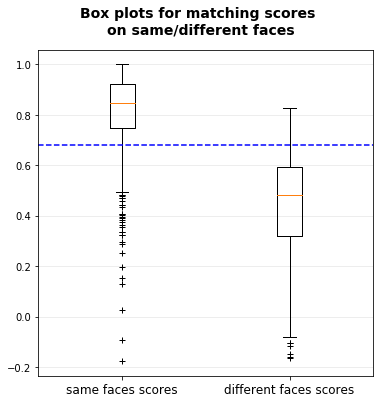

In [121]:
threshold = 0.68
data = [same_scores, diff_scores]
fig, ax = plt.subplots(figsize=(6, 6))
fig.suptitle('Box plots for matching scores \non same/different faces', fontsize=14, fontweight='bold')
bp = ax.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.set_xticklabels(['same faces scores', 'different faces scores'], fontsize=12)
plt.axhline(y=threshold, color='b', linestyle='--')
plt.show()

### <a name="1_2_5">1.2.5 Evaluating the classification threshold</a>
***
*The commented out code is a block of code that I already ran an stored its results*.<br><br>
We can see that this threshold turns out to balance between the accuracy of the same faces and the different faces.

In [123]:
# same = 0
# diff = 0
# for pair in val_same:
#     i, j, label = pair
#     left, right = train_val_data[i][0], train_val_data[j][0]
#     score = compute_similarity(left, right)
#     if (score > threshold):
#         same += 1
# for pair in val_diff:
#     i, j, label = pair
#     left, right = train_val_data[i][0], train_val_data[j][0]
#     score = compute_similarity(left, right)
#     if (score < threshold):
#         diff += 1
        
# same_acc = np.round(same / len(val_same), 4)
# diff_acc = np.round(diff / len(val_diff), 4)
# overall_acc = np.round((same + diff) / (len(val_same) + len(val_diff)), 4)

# np.save('threshold_68_acc', np.array([same_acc, diff_acc, overall_acc]))
accuracies = np.load('threshold_68_acc.npy')
print("same faces accuracy: {0} \ndifferent faces accuracy: {1} \noverall accuracy: {2}".format(accuracies[0], accuracies[1], accuracies[2]))

same faces accuracy: 0.8723 
different faces accuracy: 0.9105 
overall accuracy: 0.9068


## <a name="1_3">1.3 Perceptron</a>
***
- #### [1.3.1 Defining the MLP architecture](#1_3_1)
- #### [1.3.2 Split the data into train/validation sets](#1_3_2)
- #### [1.3.3 Defining the similarity function](#1_3_3)
- #### [1.3.4 Choosing the right threshold](#1_3_4)
- #### [1.3.5 Evaluating the classification threshold](#1_3_5)

### <a name="1_3_1">1.3.1 Defining the MLP architecture</a>
***
The inpur representation to the MLP is just a pair of images concatenated. The output contains only 2 units (softmax classification). <br>

*The commented out code of the MLP is a code that I ran on Google Colab GPU, and saved the results to be shown here later*

In [92]:
# # define two sets of inputs
# inputLeft = tf.keras.layers.Input(shape=(64, 64, 3))
# flatInputLeft = tf.keras.layers.Flatten()(inputLeft)
# inputRight = tf.keras.layers.Input(shape=(64, 64, 3))
# flatInputRight = tf.keras.layers.Flatten()(inputRight)
 
# # the first branch operates on the first input
# x = tf.keras.layers.Dense(256, activation="linear")(flatInputLeft)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(128, activation="linear")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.ReLU()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.models.Model(inputs=inputLeft, outputs=x)
 
# # the first branch operates on the first input
# y = tf.keras.layers.Dense(256, activation="linear")(flatInputRight)
# y = tf.keras.layers.BatchNormalization()(y)
# y = tf.keras.layers.ReLU()(y)
# y = tf.keras.layers.Dropout(0.2)(y)
# y = tf.keras.layers.Dense(128, activation="linear")(y)
# y = tf.keras.layers.BatchNormalization()(y)
# y = tf.keras.layers.ReLU()(y)
# y = tf.keras.layers.Dropout(0.2)(y)
# y = tf.keras.models.Model(inputs=inputRight, outputs=y)
 
# # combine the output of the two branches
# combined = tf.keras.layers.concatenate([x.output, y.output])
 
# # apply a FC layer and then a regression prediction on the combined outputs
# z = tf.keras.layers.Dense(64, activation="linear")(combined)
# z = tf.keras.layers.BatchNormalization()(z)
# z = tf.keras.layers.ReLU()(z)
# z = tf.keras.layers.Dropout(0.1)(z)
# z = tf.keras.layers.Dense(32, activation="linear")(z)
# z = tf.keras.layers.BatchNormalization()(z)
# z = tf.keras.layers.ReLU()(z)
# z = tf.keras.layers.Dropout(0.1)(z)
# z = tf.keras.layers.Dense(16, activation="linear")(z)
# z = tf.keras.layers.BatchNormalization()(z)
# z = tf.keras.layers.ReLU()(z)
# z = tf.keras.layers.Dense(2, activation="softmax")(z)
 
# # our model will accept the inputs of the two branches and then output a single value
# image_mlp = tf.keras.models.Model(inputs=[x.input, y.input], outputs=z)

# adam = tf.keras.optimizers.Adam(learning_rate=1e-3,  decay=1e-2, amsgrad=True)
# image_mlp.compile(optimizer=adam,
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])

# image_mlp.fit_generator(generator=train_generator, 
#                         validation_data=val_generator, 
#                         use_multiprocessing=True, 
#                         workers=6, 
#                         epochs=30)

In [174]:
class DataGenerator(tf.keras.utils.Sequence):
  # reference -> https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
    def __init__(self, list_IDs, labels, batch_size=64, dim=(64,64), n_channels=3,
                       n_classes=2, shuffle=True, data=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.data = data
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __normalize(self, x):
        x_min = np.amin(x)
        x_max = np.amax(x)
        return (x - x_min) / (x_max - x_min)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_left = []
        X_right = []
        X = []
        y = []

        # Generate data
        for i, j, label in list_IDs_temp:
            # Store sample

            x_left = self.data[i][0]#self.__normalize(self.data[i][0])
            x_right = self.data[j][0]#self.__normalize(self.data[j][0])
            # print(x_left.shape, x_right.shape, label)
            x_left = skimage.color.rgb2gray(x_left)
            x_right = skimage.color.rgb2gray(x_right)
            X_left.append(x_left)
            X_right.append(x_right)

            X.append(np.concatenate([x_left, x_right], axis=1))

            # Store class
            if self.n_classes > 1:
                label = tf.keras.utils.to_categorical(label, num_classes=self.n_classes)
            y.append(label)

        X_left, X_right, X, y = np.array(X_left), np.array(X_right), np.array(X), np.array(y)
        return X, y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

In [175]:
image_mlp_path = 'mlp/image_concat_2'

from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import plot_model

json_file = open(image_mlp_path + '.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
image_mlp = model_from_json(loaded_model_json)
plot_model(image_mlp, to_file='image_mlp.png', show_shapes=True, show_layer_names=False)

image_mlp.load_weights(image_mlp_path + '.h5')
adam = tf.keras.optimizers.Adam(learning_rate=1e-3,  decay=1e-2, amsgrad=True)
image_mlp.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [176]:
train_generator     = DataGenerator(train_pairs,     labels=[], data=train_val_data, batch_size=32,  n_classes=2)
val_generator       = DataGenerator(val_pairs,       labels=[], data=train_val_data, batch_size=32,  n_classes=2)
test_generator      = DataGenerator(test_pairs,      labels=[], data=test_data,      batch_size=128, n_classes=2)
test_generator_same = DataGenerator(test_pairs_same, labels=[], data=test_data,      batch_size=128, n_classes=2)
test_generator_diff = DataGenerator(test_pairs_diff, labels=[], data=test_data,      batch_size=128, n_classes=2)

In [177]:
val_loss, val_acc = image_mlp.evaluate_generator(generator=val_generator, verbose=0, max_queue_size=5)
print("val loss: {0} - val accuracy: {1}".format(val_loss, val_acc))

val loss: 0.34371803702769527 - val accuracy: 0.9197789430618286


# 4

In [178]:
same_loss, same_acc = image_mlp.evaluate_generator(generator=test_generator_same, verbose=0, max_queue_size=5)
diff_loss, diff_acc = image_mlp.evaluate_generator(generator=test_generator_diff, verbose=0, max_queue_size=5)
image_mlp_results = [same_loss, same_acc, diff_loss, diff_acc]
np.save('image_mlp_results', image_mlp_results)

In [179]:
same_loss, same_acc, diff_loss, diff_acc = np.load('image_mlp_results.npy')
print("same loss: {0} - same accuracy: {1}\ndifferent loss: {2} - different accuracy: {3}".format(same_loss, same_acc, diff_loss, diff_acc))

same loss: 0.08933231302283028 - same accuracy: 0.9691051244735718
different loss: 1.0048775481661474 - different accuracy: 0.5789708495140076


In [166]:
same = 0
diff = 0
for pair in test_pairs_same:
    i, j, _ = pair
    left, right = test_data[i][0], test_data[j][0]
    score = compute_similarity(left, right)
    if (score > threshold):
        same += 1
for pair in test_pairs_diff:
    i, j, _ = pair
    left, right = test_data[i][0], test_data[j][0]
    score = compute_similarity(left, right)
    if (score < threshold):
        diff += 1
        
same_acc = np.round(same / len(test_pairs_same), 4)
diff_acc = np.round(diff / len(test_pairs_diff), 4)
overall_acc = np.round((same + diff) / (len(test_pairs_same) + len(test_pairs_diff)), 4)
np.save('test_threshold', [same_acc, diff_acc, overall_acc])

KeyboardInterrupt: 

In [ ]:
same_acc, diff_acc, overall_acc = np.load('test_threshold.npy')
print(same_acc, diff_acc, overall_acc)

# 5

In [140]:
sobel_mlp_path = 'mlp/sobel_concat_2'

from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import plot_model

json_file = open(sobel_mlp_path + '.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
sobel_mlp = model_from_json(loaded_model_json)
plot_model(sobel_mlp, to_file='sobel_mlp.png', show_shapes=True, show_layer_names=False)

sobel_mlp.load_weights(sobel_mlp_path + '.h5')
adam = tf.keras.optimizers.Adam(learning_rate=1e-3,  decay=1e-2, amsgrad=True)
sobel_mlp.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [141]:
edges_train_val_data = []
edges_test_data = []

for item in train_val_data:
    img, _, filename = item
    edges = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.equalizeHist(edges)
    sobel_hor = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=5)
    sobel_ver = cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=5)
    edges = sobel_hor + sobel_ver
    edges_train_val_data.append((edges, filename))

for item in test_data:
    img, _, filename = item
    edges = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.equalizeHist(edges)
    sobel_hor = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=5)
    sobel_ver = cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=5)
    edges = sobel_hor + sobel_ver
    edges_test_data.append((edges, filename))

In [142]:
train_generator =     DataGenerator(train_pairs,     labels=[], data=edges_train_val_data, batch_size=32,  n_classes=2)
val_generator =       DataGenerator(val_pairs,       labels=[], data=edges_train_val_data, batch_size=32,  n_classes=2)
test_generator =      DataGenerator(test_pairs,      labels=[], data=edges_test_data,      batch_size=128, n_classes=2)
test_generator_same = DataGenerator(test_pairs_same, labels=[], data=edges_test_data,      batch_size=128, n_classes=2)
test_generator_diff = DataGenerator(test_pairs_diff, labels=[], data=edges_test_data,      batch_size=128, n_classes=2)

In [143]:
# model = tf.keras.models.Sequential()

# model.add(tf.keras.layers.Flatten(input_shape=(64, 128)))
# model.add(tf.keras.layers.Dense(units=512, activation='linear')
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.ReLU())
# model.add(tf.keras.layers.Dropout(0.4))

# model.add(tf.keras.layers.Dense(256, activation='linear')
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.ReLU())
# model.add(tf.keras.layers.Dropout(0.4))

# model.add(tf.keras.layers.Dense(128, activation='linear')
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.ReLU())
# model.add(tf.keras.layers.Dropout(0.4))

# model.add(tf.keras.layers.Dense(32, activation='linear')
# model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.ReLU())
# model.add(tf.keras.layers.Dropout(0.2))

# model.add(tf.keras.layers.Dense(2, activation='softmax'))

In [144]:
val_loss, val_acc = sobel_mlp.evaluate_generator(generator=val_generator, verbose=0, max_queue_size=5)
print("val loss: {0} - val accuracy: {1}".format(val_loss, val_acc))

val loss: 0.311970848460943 - val accuracy: 0.941120445728302


In [145]:
same_loss, same_acc = sobel_mlp.evaluate_generator(generator=test_generator_same, verbose=0, max_queue_size=5)
diff_loss, diff_acc = sobel_mlp.evaluate_generator(generator=test_generator_diff, verbose=0, max_queue_size=5)
sobel_mlp_results = [same_loss, same_acc, diff_loss, diff_acc]
np.save('sobel_mlp_results', sobel_mlp_results)

In [146]:
same_loss, same_acc, diff_loss, diff_acc = np.load('sobel_mlp_results.npy')
print("same loss: {0} - same accuracy: {1}\ndifferent loss: {2} - different accuracy: {3}".format(same_loss, same_acc, diff_loss, diff_acc))

same loss: 0.6883313809380387 - same accuracy: 0.802675187587738
different loss: 0.11346024669354826 - different accuracy: 0.9540323615074158
